# Group Connection Testing


In this notebook we will be testing whether the hemispheres/segments come from an stochastic block model, which models graphs containing communities, in which subsets of nodes within each community are characterized as being connected to each other with particular edge densities. Here, our communities are determined by the classes of the neurons within each hemisphere/segment, which we are considering can be interneuron, motorneuron, or sensory neuron.

In [1]:
import logging
import pandas as pd
import numpy as np
import csv
import networkx as nx
import itertools
import seaborn as sns
from pathlib import Path
from networkx import from_pandas_adjacency
from itertools import chain, combinations
from matplotlib import pyplot as plt
from collections import namedtuple
from graspologic.inference import group_connection_test
from graspologic.plot import heatmap, adjplot
from pkg.platy import _get_folder, load_connectome_normal_lcc_annotations, load_left_adj_labels, load_right_adj_labels, load_head_adj_labels, load_pygidium_adj_labels, load_0_adj_labels, load_1_adj_labels, load_2_adj_labels, load_3_adj_labels


In [2]:
folder = _get_folder()
annotations = load_connectome_normal_lcc_annotations()
folder

PosixPath('/Users/kareefullah/Desktop/NeuroData/neurodata/platy-data/docs/outputs')

The following blocks of code generate dataframes, where the skids_df represent the skids of interest in the hemispheres/segments and labels_df represent the corresponding labels of the classes of the neurons

In [21]:
left_adj, _ = load_left_adj_labels()
left_adj_index = list(left_adj.index)

right_adj, _ = load_right_adj_labels()
right_adj_index = list(right_adj.index)

all_hemi_index  = left_adj_index + right_adj_index
all_hemi_index = [int(i) for i in all_hemi_index]

skids_hemis = {"l": [], "r": []}
labels_hemis = {"l": [], "r": []}
poss_labels = ["s", "i", "m"]

#add skids and labels for hemis;
for key in skids_hemis:
    for i in range(len(annotations["skids"])):

        #check if the skid is in the left/right adj (normal, lcc), and the side is left or right, and the class exists as sensory, motor, or inter
        if(annotations["skids"][i] in all_hemi_index and annotations["side"][i]==key and annotations["class"][i] in poss_labels):
            skids_hemis[key].append(annotations["skids"][i])
            labels_hemis[key].append(annotations["class"][i])

#convert dicts to dataframes
skids_hemis_df = pd.DataFrame(dict([(k, pd.Series(v)) for k,v in skids_hemis.items()]))
labels_hemis_df = pd.DataFrame(dict([(k, pd.Series(v)) for k,v in labels_hemis.items()]))
skids_hemis_df.to_csv(folder / "skids_hemis_classes.csv")
labels_hemis_df.to_csv(folder / "labels_hemis_classes.csv")

{'l': [2015233,
  1318919,
  2015241,
  1417265,
  1318965,
  1278006,
  1318986,
  1278038,
  1130583,
  1024095,
  1278051,
  385141,
  827510,
  1302663,
  1736843,
  344239,
  1736887,
  1065166,
  57553,
  508114,
  1065178,
  1155295,
  73954,
  409861,
  1311006,
  1392926,
  1401122,
  1360179,
  1392970,
  16719,
  2015571,
  1442134,
  1335645,
  2007389,
  1212800,
  1089948,
  1261995,
  1499594,
  2015704,
  1335777,
  1335790,
  1335832,
  1950241,
  1335845,
  1278565,
  1155695,
  1827444,
  1278598,
  1294986,
  1950393,
  2015926,
  1360579,
  1696456,
  1639124,
  2015966,
  1278688,
  172769,
  1278697,
  74477,
  1303297,
  1950485,
  115486,
  1278774,
  41848,
  1377175,
  1704860,
  1565599,
  1377191,
  1631145,
  1278903,
  1360843,
  656354,
  1278947,
  1516536,
  1287162,
  1377274,
  1360893,
  1721342,
  1295406,
  1500207,
  1860656,
  1156145,
  1975364,
  1074256,
  1090653,
  1082470,
  1279078,
  1303655,
  1729648,
  1393787,
  1541262,
  1295517,
 

In [22]:
head_adj, _ = load_head_adj_labels()
head_adj_index = list(head_adj.index)

pyg_adj, _ = load_pygidium_adj_labels()
pyg_adj_index = list(pyg_adj.index)

#adj_0, _ = load_0_adj_labels()
#adj_0_index = list(adj_0.index)

adj_1, _ = load_1_adj_labels()
adj_1_index = list(adj_1.index)

adj_2, _ = load_2_adj_labels()
adj_2_index = list(adj_2.index)

adj_3, _ = load_3_adj_labels()
adj_3_index = list(adj_3.index)

all_segs_index  = head_adj_index + pyg_adj_index + adj_1_index + adj_2_index + adj_3_index
all_segs_index = [int(i) for i in all_segs_index]

skids_segs = {"head": [], "pygidium": [], "1": [], "2": [], "3": []}
labels_segs = {"head": [], "pygidium": [], "1": [], "2": [], "3": []}

for key in skids_segs:
    for i in range(len(annotations["skids"])):
        if(annotations["skids"][i] in all_segs_index and annotations["segment"][i]==key and annotations["class"][i] in poss_labels):
            skids_segs[key].append(annotations["skids"][i])
            labels_segs[key].append(annotations["class"][i])

skids_segs_df = pd.DataFrame(dict([(k, pd.Series(v)) for k,v in skids_segs.items()]))
labels_segs_df = pd.DataFrame(dict([(k, pd.Series(v)) for k,v in labels_segs.items()]))
skids_segs_df.to_csv(folder / "skids_segs_classes.csv")
labels_segs_df.to_csv(folder / "labels_segs_classes.csv")

In [23]:
new_folder = Path.joinpath(folder, "group_connection_plots")
new_folder

PosixPath('/Users/kareefullah/Desktop/NeuroData/neurodata/platy-data/docs/outputs/group_connection_plots')

In [24]:
#comparison for hemis
count_hemis = {"l" : {"s": 0, "i": 0, "m": 0}, "r": {"s": 0, "i": 0, "m": 0}}

for key in count_hemis:
    for i in range(len(labels_hemis[key])):
        count_hemis[key][labels_hemis[key][i]] += 1

# get the lists of number of skids for y values, x values are the keys
keys = poss_labels # "s", "i", "m"
list_counts_hemis = []
class_label_hemis = []
hemi_label = []
# loop through "l" and "r"
for key in count_hemis:
    # loop through "s", "i", "m"
    for inner_key in count_hemis[key]:
        # append "s" "i" or "m"
        class_label_hemis.append(inner_key)
        # add 1 to the count of the respective class label in the respective key of count_hemis
        list_counts_hemis.append(count_hemis[key][inner_key])
        # append the outer key from count_hemis
        hemi_label.append(key)

label_counts = list(zip(class_label_hemis, list_counts_hemis, hemi_label))
df_hemis = pd.DataFrame(label_counts, columns = ["class", "count", "side"])
df_hemis.to_csv(new_folder / "hemi_classes_counts.csv")
df_hemis

,class,count,side
0,s,228,l
1,i,348,l
2,m,86,l
3,s,219,r
4,i,353,r
5,m,95,r


We make barplots for the counts of each of the classes across the hemispheres/segments using the dictionaries we generated above

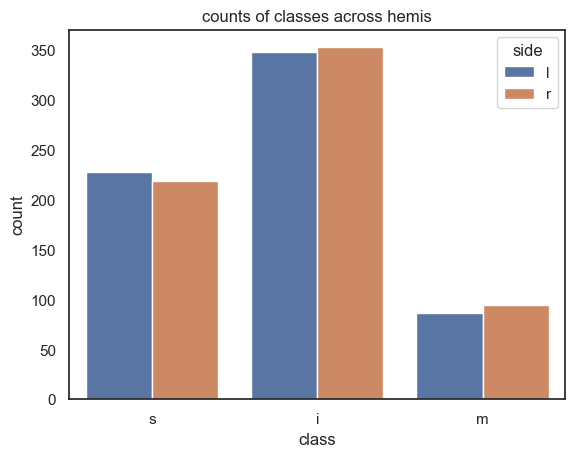

In [25]:
sns.set(style="white")
sns.barplot(x="class", y="count", hue="side", data=df_hemis)
plt.title("counts of classes across hemis")
plt.savefig(new_folder / "hemi_classes_barplot.png")

In [26]:

#comparison for segments
count_segs = {"head" : {"s": 0, "i": 0, "m": 0},
              "pygidium": {"s": 0, "i": 0, "m": 0},
              "1" : {"s": 0, "i": 0, "m": 0},
              "2" : {"s": 0, "i": 0, "m": 0},
              "3" : {"s": 0, "i": 0, "m": 0},}

for key in count_segs:
    for i in range(len(labels_segs[key])):
        count_segs[key][labels_segs[key][i]] += 1
print(count_segs)
# get the lists of number of skids for y values, x values are the keys
keys = poss_labels # "s", "i", "m"
list_counts_segs = []
class_label_segs = []
segs_label = []
# loop through "l" and "r"
for key in count_segs:
    # loop through "s", "i", "m"
    for inner_key in count_segs[key]:
        # append "s" "i" or "m"
        class_label_segs.append(inner_key)
        # add 1 to the count of the respective class label in the respective key of count_hemis
        list_counts_segs.append(count_segs[key][inner_key])
        # append the outer key from count_hemis
        segs_label.append(key)

label_counts_segs = list(zip(class_label_segs, list_counts_segs, segs_label))
df_segs = pd.DataFrame(label_counts_segs, columns = ["class", "count", "segment"])
df_segs.to_csv(new_folder / "segs_classes_counts.csv")
df_segs

{'head': {'s': 298, 'i': 324, 'm': 20}, 'pygidium': {'s': 38, 'i': 12, 'm': 1}, '1': {'s': 21, 'i': 111, 'm': 43}, '2': {'s': 38, 'i': 144, 'm': 67}, '3': {'s': 38, 'i': 96, 'm': 49}}


,class,count,segment
0,s,298,head
1,i,324,head
2,m,20,head
3,s,38,pygidium
4,i,12,pygidium
5,m,1,pygidium
6,s,21,1
7,i,111,1
8,m,43,1
9,s,38,2


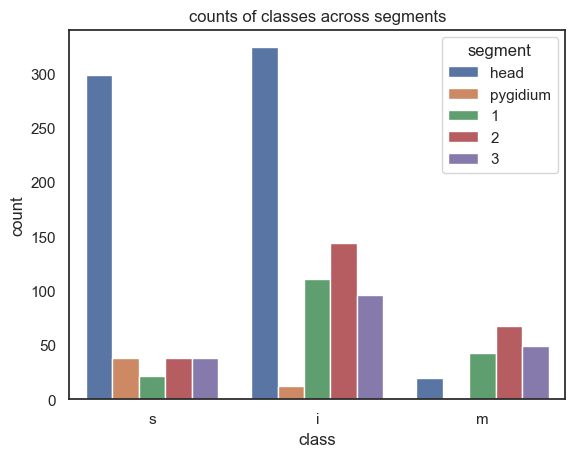

In [27]:
sns.set(style="white")
sns.barplot(x="class", y="count", hue="segment", data=df_segs)
plt.title("counts of classes across segments")
plt.savefig(new_folder / "segs_classes_barplot.png")

We will now visualize the adjs of the hemispheres/segments, in which the nodes will be grouped into communities of sensory, motor, or interneurons

In [28]:
from pkg.platy import load_0_adj_labels, load_1_adj_labels, load_2_adj_labels, load_3_adj_labels, load_right_adj_labels, load_left_adj_labels, load_head_adj_labels, load_pygidium_adj_labels

#block for loading adjs/labels

#hemis
left_adj, left_labels = load_left_adj_labels()
right_adj, right_labels = load_right_adj_labels()

#segments
head_adj, head_labels = load_head_adj_labels()
pyg_adj, pyg_labels = load_pygidium_adj_labels()
#adj_0, labels_0 = load_0_adj_labels()
adj_1, labels_1 = load_1_adj_labels()
adj_2, labels_2 = load_2_adj_labels()
adj_3, labels_3 = load_3_adj_labels()

In [29]:
#lists for adjs/labels/names
hemi_adjs = [left_adj, right_adj]
for i, val in enumerate(hemi_adjs):
    hemi_adjs[i] = val.to_numpy()

segment_adjs = [head_adj, pyg_adj, adj_1, adj_2, adj_3]
for i, val in enumerate(segment_adjs):
    segment_adjs[i] = val.to_numpy()
all_adjs = hemi_adjs + segment_adjs

hemi_labels = [left_labels, right_labels]
segment_labels = [head_labels, pyg_labels, labels_1, labels_2, labels_3]
all_labels = hemi_labels + segment_labels

hemi_names = ["left", "right"]
segment_names = ["head", "pygidium", "1", "2", "3"]
all_names = hemi_names + segment_names

In [30]:
#scatterplots

#metadata
metas = []
for i in range(len(all_adjs)):
    metas.append(pd.DataFrame(
        data={
              "{}_labels".format(all_names[i]): all_labels[i]
        },
))

for i in range(len(all_adjs)):
    #group_order parameter - make all s have group order 0 etc
    adjplot(all_adjs[i], plot_type="scattermap", meta=metas[i], group=["{}_labels".format(all_names[i])])
    plt.savefig(new_folder / "scatterplots" / "connection_{}".format(all_names[i]))

ValueError: Length of meta must be the same as corresponding data axis

In [31]:
metas

[    left_labels
 0             s
 1             s
 2             s
 3             i
 4             i
 ..          ...
 657           i
 658           i
 659           s
 660           s
 661           i
 
 [662 rows x 1 columns],
     right_labels
 0              s
 1              i
 2              m
 3              m
 4              i
 ..           ...
 662            s
 663            s
 664            i
 665            m
 666            m
 
 [667 rows x 1 columns],
     head_labels
 0             s
 1             s
 2             s
 3             i
 4             i
 ..          ...
 637           s
 638           s
 639           s
 640           i
 641           s
 
 [642 rows x 1 columns],
    pygidium_labels
 0                s
 1                s
 2                s
 3                s
 4                s
 5                s
 6                i
 7                s
 8                s
 9                i
 10               s
 11               s
 12               s
 13            

In [16]:
metas

[    left_labels
 0             s
 1             s
 2             s
 3             i
 4             i
 ..          ...
 657           i
 658           i
 659           s
 660           s
 661           i
 
 [662 rows x 1 columns],
     right_labels
 0              s
 1              i
 2              m
 3              m
 4              i
 ..           ...
 662            s
 663            s
 664            i
 665            m
 666            m
 
 [667 rows x 1 columns],
     head_labels
 0             s
 1             s
 2             s
 3             i
 4             i
 ..          ...
 637           s
 638           s
 639           s
 640           i
 641           s
 
 [642 rows x 1 columns],
    pygidium_labels
 0                s
 1                s
 2                s
 3                s
 4                s
 5                s
 6                i
 7                s
 8                s
 9                i
 10               s
 11               s
 12               s
 13            

In [7]:
# skids_left = pymaid.get_skids_by_annotation("left")
# skids_right = pymaid.get_skids_by_annotation("right")
# skids_head = pymaid.get_skids_by_annotation("head")
# skids_pygidium = pymaid.get_skids_by_annotation("pygidium")
# skids_0 = pymaid.get_skids_by_annotation("segment_0")
# skids_1 = pymaid.get_skids_by_annotation("segment_1")
# skids_2 = pymaid.get_skids_by_annotation("segment_2")
# skids_3 = pymaid.get_skids_by_annotation("segment_3")

In [8]:
#don't think i need this
# df_left = pymaid.adjacency_matrix(skids_left)
# df_right = pymaid.adjacency_matrix(skids_right)
# df_head = pymaid.adjacency_matrix(skids_head)
# df_pygidium = pymaid.adjacency_matrix(skids_pygidium)
# df_0 = pymaid.adjacency_matrix(skids_0)
# df_1 = pymaid.adjacency_matrix(skids_1)
# df_2 = pymaid.adjacency_matrix(skids_2)
# df_3 = pymaid.adjacency_matrix(skids_3)

In [9]:
# skids_sensory = pymaid.get_skids_by_annotation("Sensory neuron")
# skids_inter = pymaid.get_skids_by_annotation("interneuron")
# skids_motor = pymaid.get_skids_by_annotation("motorneuron")

In [10]:
# def class_labels(skids, skids_sensory, skids_inter, skids_motor):
#     new_skids = []
#     labels = []
#     for i, skid in enumerate(skids):
#         if skid in skids_sensory:
#             labels.append("s")
#             new_skids.append(skid)
#         elif skid in skids_inter:
#             labels.append("i")
#             new_skids.append(skid)
#         elif skid in skids_motor:
#             labels.append("m")
#             new_skids.append(skid)

#     return new_skids, labels

In [11]:
# left_new, left_labels = class_labels(skids_left, skids_sensory, skids_inter, skids_motor)
# right_new, right_labels = class_labels(skids_right, skids_sensory, skids_inter, skids_motor)
# head_new, head_labels = class_labels(skids_head, skids_sensory, skids_inter, skids_motor)
# pygidium_new, pygidium_labels = class_labels(skids_pygidium, skids_sensory, skids_inter, skids_motor)
# seg0_new, seg0_labels = class_labels(skids_0, skids_sensory, skids_inter, skids_motor)
# seg1_new, seg1_labels = class_labels(skids_1, skids_sensory, skids_inter, skids_motor)
# seg2_new, seg2_labels = class_labels(skids_2, skids_sensory, skids_inter, skids_motor)
# seg3_new, seg3_labels = class_labels(skids_3, skids_sensory, skids_inter, skids_motor)
# len(seg0_new)

In [12]:
# df_left = pymaid.adjacency_matrix(left_new)
# df_right = pymaid.adjacency_matrix(right_new)
# df_head = pymaid.adjacency_matrix(head_new)
# df_pygidium = pymaid.adjacency_matrix(pygidium_new)
# df_0 = pymaid.adjacency_matrix(seg0_new)
# df_1 = pymaid.adjacency_matrix(seg1_new)
# df_2 = pymaid.adjacency_matrix(seg2_new)
# df_3 = pymaid.adjacency_matrix(seg3_new)

In [13]:
# left_adj = df_left.to_numpy()
# right_adj = df_right.to_numpy()
# head_adj = df_head.to_numpy()
# pygidium_adj = df_pygidium.to_numpy()
# seg0_adj = df_0.to_numpy()
# seg1_adj = df_1.to_numpy()
# seg2_adj = df_2.to_numpy()
# seg3_adj = df_3.to_numpy()

In [14]:
# all_adjs = [left_adj, right_adj, head_adj, pygidium_adj, seg0_adj, seg1_adj, seg2_adj, seg3_adj]
# pairwise_adjs = list(itertools.combinations(all_adjs, 2))
# len(pairwise_adjs)

In [15]:
# stat, pval, misc = group_connection_test(left_adj, right_adj, left_labels, right_labels)
# pval